In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline


warnings.filterwarnings("ignore")

%matplotlib inline

In [80]:
df = pd.read_csv(r"C:\Users\wasim\tourism_package\packagePrediction\data\Travel.csv")

In [81]:
df.shape

(4888, 20)

In [82]:
percentage = df.ProdTaken.value_counts(normalize=True)*100
pielabels = ["Not-Bought","Bought"]

# Plot PieChart with Ploty library
f1 = px.pie(values= percentage, names= pielabels, title="Percentage of package bought and not bought")
f1.update_traces(textposition="inside", textinfo="percent+label")
f1.update_layout(margin={"r":50,"t":50,"l":50,"b":50})
f1.show()

In [83]:
# Age
df['Age'].fillna(df['Age'].mean(), inplace=True)

# TypeofContact
df['TypeofContact'].fillna(df['TypeofContact'].mode()[0], inplace=True)

# DurationOfPitch
df['DurationOfPitch'].fillna(df['DurationOfPitch'].median(), inplace=True)

# NumberOfFollowups
df['NumberOfFollowups'].fillna(df['NumberOfFollowups'].mode()[0], inplace=True)

# PreferredPropertyStar
df['PreferredPropertyStar'].fillna(df['PreferredPropertyStar'].mode()[0], inplace=True)

# NumberOfTrips
df['NumberOfTrips'].fillna(0, inplace=True)

# NumberOfChildrenVisiting
df['NumberOfChildrenVisiting'].fillna(df['NumberOfChildrenVisiting'].mode()[0], inplace=True)

# MonthlyIncome
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)

In [84]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder


numerical_columns = ['Age', 'TypeofContact', 'CityTier',
                            'DurationOfPitch', 'NumberOfPersonVisiting',
                            'NumberOfFollowups', 'PreferredPropertyStar',
                            'NumberOfTrips', 'Passport', 'PitchSatisfactionScore',
                            'OwnCar', 'NumberOfChildrenVisiting', 'MonthlyIncome']
categorical_columns = ['TypeofContact', 'Occupation', 'Gender', 'ProductPitched',
                 'MaritalStatus', 'Designation']

continuous_columns = [i for i in df.columns if df[i].nunique() > 8]
continuous_columns.remove("CustomerID")

enc = OrdinalEncoder()
df[categorical_columns] = enc.fit_transform(df[categorical_columns])

print(numerical_columns)

['Age', 'TypeofContact', 'CityTier', 'DurationOfPitch', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar', 'NumberOfChildrenVisiting', 'MonthlyIncome']


In [85]:
from collections import Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler  

X = df.drop(columns=['ProdTaken', 'CustomerID'], axis=1)
y = df['ProdTaken']

# summarize class distribution
counter = Counter(y)
print(counter)
# define pipeline
over = RandomOverSampler(random_state=42)

# transform the dataset
X, y = over.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

X.shape, y.shape

Counter({0: 3968, 1: 920})
Counter({1: 3968, 0: 3968})


((7936, 18), (7936,))

In [86]:
import math
from sklearn.model_selection import StratifiedShuffleSplit

X[X.columns] = X[X.columns].apply(np.ceil) 
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(X_train.shape, X_test.shape)

df = pd.concat([X_train, y_train], axis=1)

test_df = pd.concat([X_test, y_test], axis=1)
test_df.to_csv(r'C:\Users\wasim\tourism_package\packagePrediction\data\test_df.csv', index=False)

(7142, 18) (794, 18)


### Column Information
- TypeofContact: How customer was contacted (Company Invited or Self Inquiry)
- DurationOfPitch: Duration of the pitch by a salesperson to the customer
- NumberOfFollowups: Total number of follow-ups has been done by the salesperson after the sales pitch
- ProductPitched: Product pitched by the salesperson
- PreferredPropertyStar: Preferred hotel property rating by customer

# Exploratory Data Analysis 

## Descriptive Analysis
- Number of rows and columns
- Data type of features and does it makes sense
- Distribution
- Outliers?
- Mean and variance
- Understand Values

In [87]:
df.shape

(7142, 19)

In [88]:
df.dtypes

Age                         float64
TypeofContact               float64
CityTier                    float64
DurationOfPitch             float64
Occupation                  float64
Gender                      float64
NumberOfPersonVisiting      float64
NumberOfFollowups           float64
ProductPitched              float64
PreferredPropertyStar       float64
MaritalStatus               float64
NumberOfTrips               float64
Passport                    float64
PitchSatisfactionScore      float64
OwnCar                      float64
NumberOfChildrenVisiting    float64
Designation                 float64
MonthlyIncome               float64
ProdTaken                     int64
dtype: object

**Note: All the floats values can be converted to the int as it does not have any values after decimal point**

In [89]:
df.isnull().sum()

Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch             0
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
MaritalStatus               0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
OwnCar                      0
NumberOfChildrenVisiting    0
Designation                 0
MonthlyIncome               0
ProdTaken                   0
dtype: int64


**Note: There are 8 columns which has null values, so it will be fun to handle them**

### Distribution and skewness

In [90]:
print(continuous_columns)
# plt.figure(figsize=(17,75))

# for i in range(len(continuous_columns)):
#     plt.subplot(18,1,i+1)
#     sns.distplot(df[continuous_columns[i]])
#     plt.tight_layout()
#     plt.title(continuous_columns[i],fontsize=25)
    
# plt.show()


['Age', 'DurationOfPitch', 'NumberOfTrips', 'MonthlyIncome']


In [91]:
for col in continuous_columns:
    print(col,df[col].skew())

Age 0.42317275924986236
DurationOfPitch 1.4354214812471655
NumberOfTrips 1.492917528287139
MonthlyIncome 1.9543882477065895


- Positiviely Skewed : DurationOfPitch, NumberOfTrips

In [92]:
df.describe()

,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,ProdTaken
count,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000,7142.000000
mean,36.501960,0.696864,1.707925,15.836320,2.315878,1.574209,2.912069,3.795435,1.001960,3.649258,1.384206,3.182162,0.382946,3.126575,0.614814,1.187623,1.643517,22941.156679,0.500000
std,9.523734,0.459646,0.932142,8.353498,0.656251,0.554819,0.715208,1.004829,1.234112,0.827715,0.942971,1.961612,0.486139,1.356370,0.486673,0.858786,0.907298,5024.354622,0.500035
min,18.000000,0.000000,1.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1000.000000,0.000000
25%,30.000000,0.000000,1.000000,9.000000,2.000000,1.000000,2.000000,3.000000,0.000000,3.000000,1.000000,2.000000,0.000000,2.000000,0.000000,1.000000,1.000000,19941.000000,0.000000
50%,36.000000,1.000000,1.000000,13.000000,2.000000,2.000000,3.000000,4.000000,1.000000,3.000000,1.000000,3.000000,0.000000,3.000000,1.000000,1.000000,1.000000,21804.000000,0.500000
75%,42.000000,1.000000,3.000000,21.000000,3.000000,2.000000,3.000000,4.000000,1.000000,4.000000,2.000000,4.000000,1.000000,4.000000,1.000000,2.000000,2.000000,24850.000000,1.000000
max,61.000000,1.000000,3.000000,127.000000,3.000000,2.000000,5.000000,6.000000,4.000000,5.000000,3.000000,22.000000,1.000000,5.000000,1.000000,3.000000,4.000000,98678.000000,1.000000


### Exploration of Values

In [93]:
ranges = [18, 25, 35, 45, 55, 60]

not_taken_data = df[df['ProdTaken'] == 1]
print(not_taken_data.shape)

not_taken_cancelled = not_taken_data["ProdTaken"].groupby(pd.cut(df.Age, ranges)).count()
age_range_total = df["ProdTaken"].groupby(pd.cut(df.Age, ranges)).count()

not_taken_cancelled/age_range_total

(3571, 19)


Age
(18, 25]    0.754795
(25, 35]    0.547542
(35, 45]    0.394483
(45, 55]    0.390293
(55, 60]    0.566225
Name: ProdTaken, dtype: float64

#### Note: 
- Age group of 18 to 25 buy most package
- Age between  35 to 55 is lowest, as in these age groups mostly there

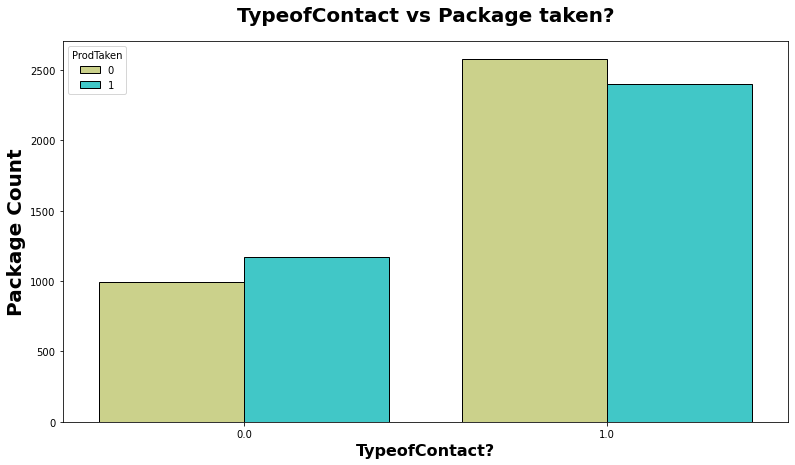

In [94]:
plt.subplots(figsize=(13,7))
sns.countplot(x="TypeofContact",hue="ProdTaken", data= df,ec = "black",palette="rainbow_r")
plt.title("TypeofContact vs Package taken?", weight="bold",fontsize=20, pad=20)
plt.ylabel("Package Count", weight="bold", fontsize=20)
plt.xlabel("TypeofContact?", weight="bold", fontsize=16)
plt.show()

**Note:**
- The Self inquiry are much more than Company Invited, company just need to capitalized on self inquiry

In [95]:
df['CityTier'].value_counts()

1.0    4450
3.0    2364
2.0     328
Name: CityTier, dtype: int64

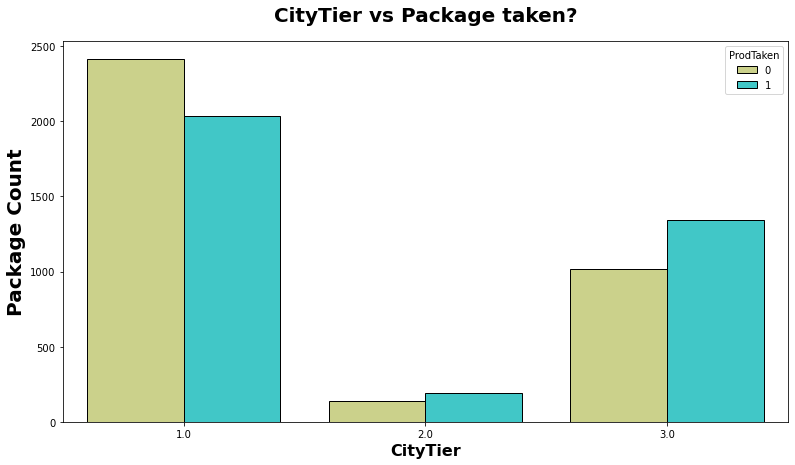

In [96]:
plt.subplots(figsize=(13,7))
sns.countplot(x="CityTier",hue="ProdTaken", data= df,ec = "black",palette="rainbow_r")
plt.title("CityTier vs Package taken?", weight="bold",fontsize=20, pad=20)
plt.ylabel("Package Count", weight="bold", fontsize=20)
plt.xlabel("CityTier", weight="bold", fontsize=16)
plt.show()

- Intresting to see that, there are more package taken from the third tier than second tier.
- It shows how middle class lives

In [97]:
pitch_less_10_and_taken = (df.loc[(df['DurationOfPitch']<10) & (df['ProdTaken'] == 1 )]).shape[0]
pitch_less_10_and_not_taken = (df.loc[(df['DurationOfPitch']<10) & (df['ProdTaken'] == 0 )]).shape[0]

pitch_between_10_30_and_taken = df.loc[(df['DurationOfPitch']<30) & (df['ProdTaken'] == 1 ) & (df['DurationOfPitch']>10)].shape[0]
pitch_between_10_30_and_not_taken = df.loc[(df['DurationOfPitch']<30) & (df['ProdTaken'] == 0) & (df['DurationOfPitch']>10)].shape[0]

pitch_more_than_30_and_taken = df.loc[(df['DurationOfPitch']>30) & (df['ProdTaken'] == 1 )].shape[0]
pitch_more_than_30_and_not_taken = df.loc[(df['DurationOfPitch']>30) & (df['ProdTaken'] == 0)].shape[0]


total_package_taken = (df.loc[(df['ProdTaken'] == 1 )]).shape[0]

print(f"Total {pitch_less_10_and_taken + pitch_less_10_and_not_taken} talks for less than 10 minutes and only {pitch_less_10_and_taken} were bought which is about {pitch_less_10_and_taken/(pitch_less_10_and_taken + pitch_less_10_and_not_taken)}")
print(f"Total {pitch_between_10_30_and_taken + pitch_between_10_30_and_not_taken} talks for between 10 and 30 minutes and only {pitch_between_10_30_and_taken} were bought which is about {pitch_between_10_30_and_taken/(pitch_between_10_30_and_taken + pitch_between_10_30_and_not_taken)}")
print(f"Total {pitch_more_than_30_and_taken + pitch_more_than_30_and_not_taken} talks for more than 30 minutes and only {pitch_more_than_30_and_taken} were bought which is about {pitch_more_than_30_and_taken/(pitch_more_than_30_and_taken + pitch_more_than_30_and_not_taken)}")
print('\n')
print(f"Out of total {total_package_taken} packages, {pitch_less_10_and_taken/total_package_taken} comes from talking less than 10 minutes, {pitch_between_10_30_and_taken/total_package_taken} comes from talking between 10 minutes and 30 minutes, and {pitch_more_than_30_and_taken/total_package_taken} comes from talking more than 30 minutes")

Total 2018 talks for less than 10 minutes and only 898 were bought which is about 0.4449950445986125
Total 4024 talks for between 10 and 30 minutes and only 2074 were bought which is about 0.5154075546719682
Total 568 talks for more than 30 minutes and only 304 were bought which is about 0.5352112676056338


Out of total 3571 packages, 0.25147017642117053 comes from talking less than 10 minutes, 0.5807896947633716 comes from talking between 10 minutes and 30 minutes, and 0.08513021562587511 comes from talking more than 30 minutes


**Note:**
- It's obvious to see very few people talk more than 30 minutes and still they are talking more than 30 minutes, buying ratio is same
- Most people talk between 10 minutes, in which most might be genuine customer and this pitch time range covers more than 50% of total package taken 

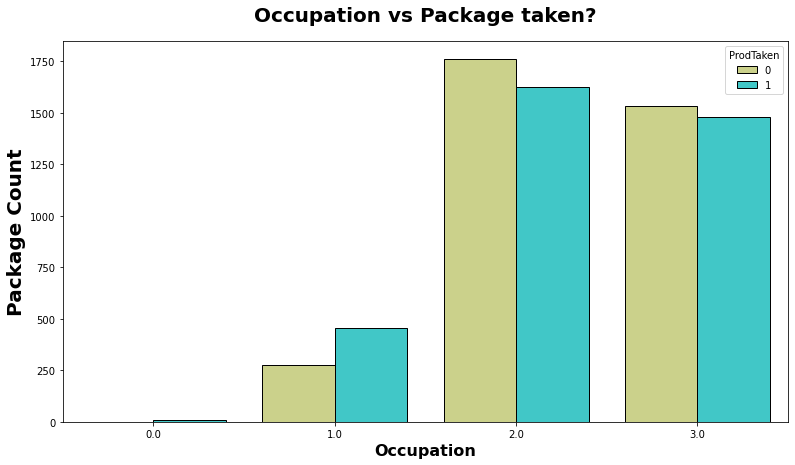

In [98]:
plt.subplots(figsize=(13,7))
sns.countplot(x="Occupation",hue="ProdTaken", data= df,ec = "black",palette="rainbow_r")
plt.title("Occupation vs Package taken?", weight="bold",fontsize=20, pad=20)
plt.ylabel("Package Count", weight="bold", fontsize=20)
plt.xlabel("Occupation", weight="bold", fontsize=16)
plt.show()

**Note:**
- All these results, seems like we have seen them in real life
- Salaried people are most, as they are secured and want some break
- We all know most of the small business owner have the policy of earn and live a life
- In the Large Business, there are very few package taken, but they seems to be sorted and their ratio of total inquiry seems to be more
- Company is lacking Freelancer inquiries, really need to work on that

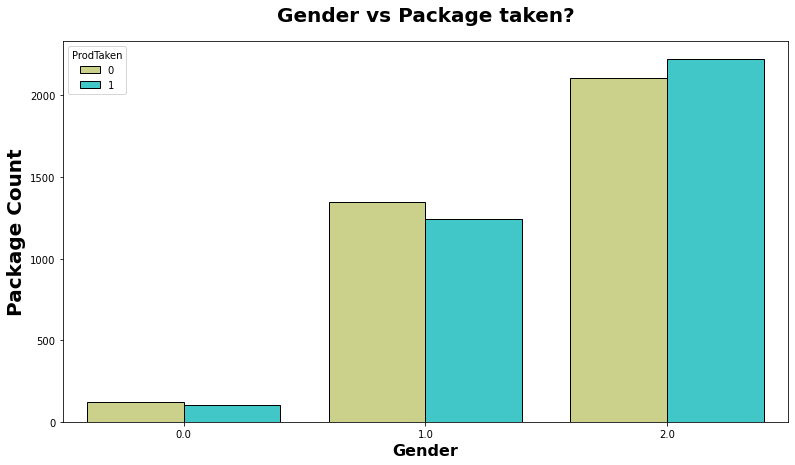

In [99]:
"""
I don't think gender would have more bias on buying package, but let's check
"""

plt.subplots(figsize=(13,7))
sns.countplot(x="Gender",hue="ProdTaken", data= df,ec = "black",palette="rainbow_r")
plt.title("Gender vs Package taken?", weight="bold",fontsize=20, pad=20)
plt.ylabel("Package Count", weight="bold", fontsize=20)
plt.xlabel("Gender", weight="bold", fontsize=16)
plt.show()

- For female, it seem that it has two values, need to replace it and then replot it 

In [100]:
df['Gender'].replace({'Fe Male': 'Female'}, inplace=True)

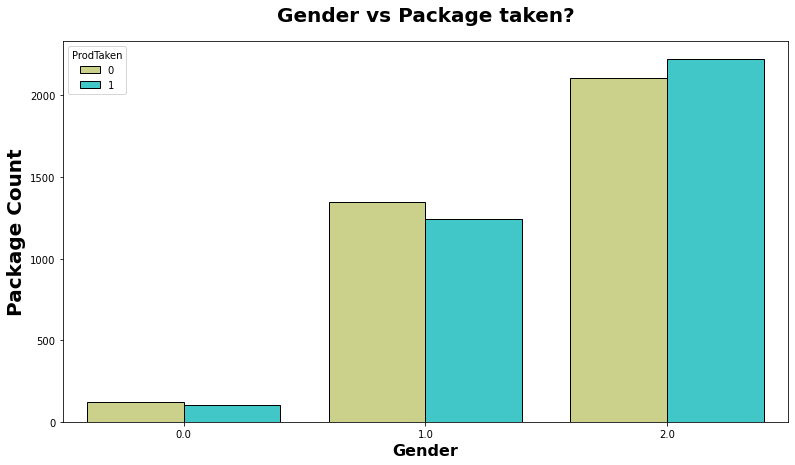

In [101]:
plt.subplots(figsize=(13,7))
sns.countplot(x="Gender",hue="ProdTaken", data= df,ec = "black",palette="rainbow_r")
plt.title("Gender vs Package taken?", weight="bold",fontsize=20, pad=20)
plt.ylabel("Package Count", weight="bold", fontsize=20)
plt.xlabel("Gender", weight="bold", fontsize=16)
plt.show()

**Note:**
- As it can be seen, there doesn't seem to difference in ration of package bought by male or female
- But we can see, amount of inquiry by female is less than male, sexism 

In [102]:
df['NumberOfPersonVisiting'].value_counts()

3.0    3542
2.0    2066
4.0    1498
1.0      33
5.0       3
Name: NumberOfPersonVisiting, dtype: int64

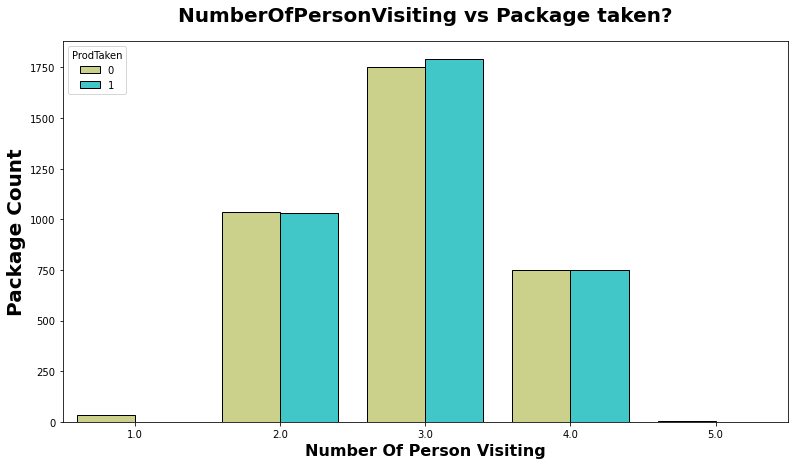

In [103]:
plt.subplots(figsize=(13,7))
sns.countplot(x="NumberOfPersonVisiting",hue="ProdTaken", data= df,ec = "black",palette="rainbow_r")
plt.title("NumberOfPersonVisiting vs Package taken?", weight="bold",fontsize=20, pad=20)
plt.ylabel("Package Count", weight="bold", fontsize=20)
plt.xlabel("Number Of Person Visiting", weight="bold", fontsize=16)
plt.show()

**Note:**
- This data also shows that most inquiries has 3 people, really need to control Population.
- Out of more than 4500 records, only 39 people has one child 

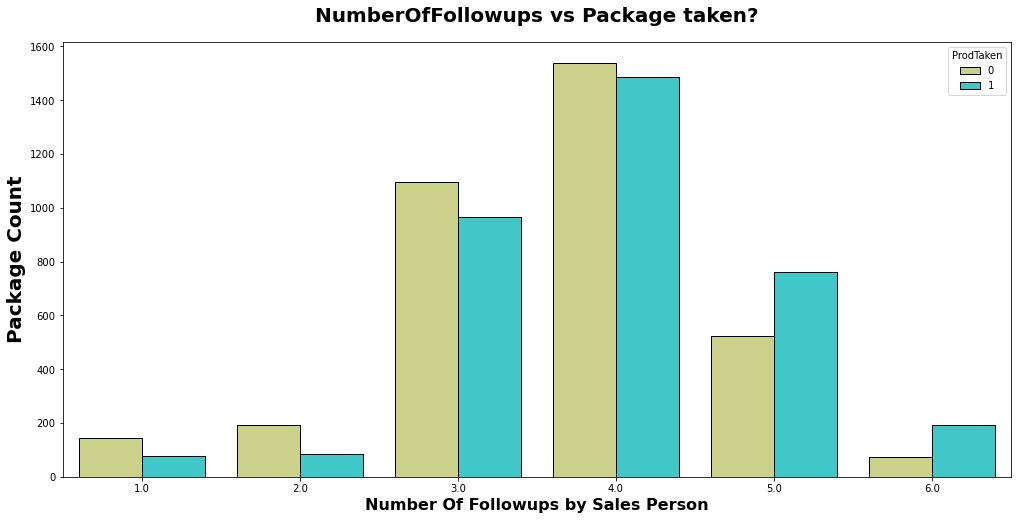

In [104]:
plt.subplots(figsize=(17,8))
sns.countplot(x="NumberOfFollowups",hue="ProdTaken", data= df,ec = "black",palette="rainbow_r")
plt.title("NumberOfFollowups vs Package taken?", weight="bold",fontsize=20, pad=20)
plt.ylabel("Package Count", weight="bold", fontsize=20)
plt.xlabel("Number Of Followups by Sales Person", weight="bold", fontsize=16)
plt.show()

I want to see like if sales person is making 4 follow ups, then Is the ratio of buying is more and graph unable to show that

In [105]:
for i in range(1, 7):
    followup_taken = df.loc[(df['NumberOfFollowups'] == i) & (df['ProdTaken'] == 1)].shape[0]
    followup_all= df.loc[(df['NumberOfFollowups'] == i)].shape[0]

    followup_ratio = followup_taken/followup_all

    print(f"For the follow up {i}, total number is {followup_all} and ratio is {followup_ratio}")


For the follow up 1, total number is 220 and ratio is 0.34545454545454546
For the follow up 2, total number is 279 and ratio is 0.30824372759856633
For the follow up 3, total number is 2062 and ratio is 0.4684772065955383
For the follow up 4, total number is 3028 and ratio is 0.4914134742404227
For the follow up 5, total number is 1287 and ratio is 0.5928515928515928
For the follow up 6, total number is 266 and ratio is 0.7218045112781954


**Note:**
- Very Few inquiries has been followed for 6 times, and they have the highest ratio
- It seem like in the second followups, people confused people has said no
- It really good to see very few people went after just 1 follow up, it shows sales team is working well

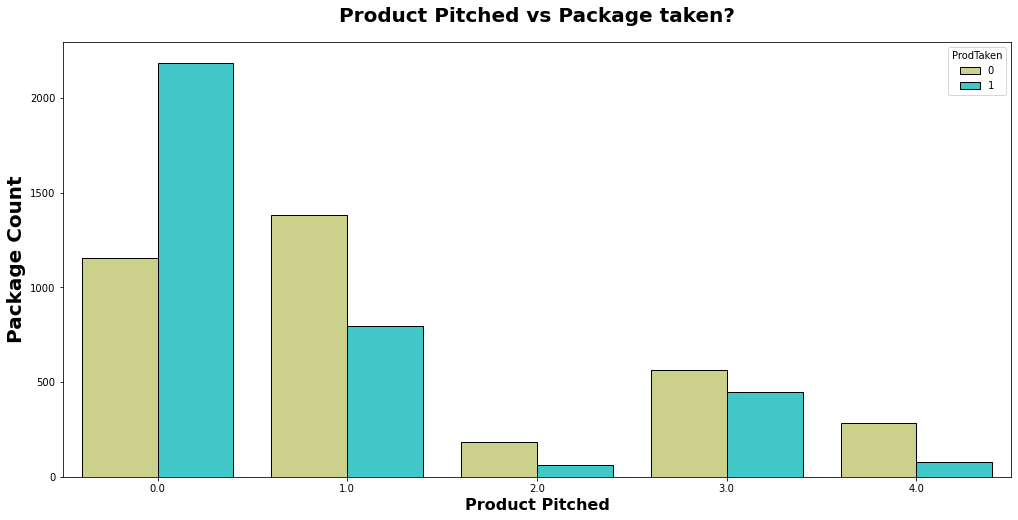

In [106]:
plt.subplots(figsize=(17,8))
sns.countplot(x="ProductPitched",hue="ProdTaken", data= df,ec = "black",palette="rainbow_r")
plt.title("Product Pitched vs Package taken?", weight="bold",fontsize=20, pad=20)
plt.ylabel("Package Count", weight="bold", fontsize=20)
plt.xlabel("Product Pitched", weight="bold", fontsize=16)
plt.show()

**Note:**
- Super Deluxe and King are pitched very less and their buying count seems to be very low, need to work on this
- Deluxe is pitched maximum but not bought and Basic is pitched less and count of buying is also good.
- So, need to pitched more standard, super Deluxe and King. And less focus on Deluxe

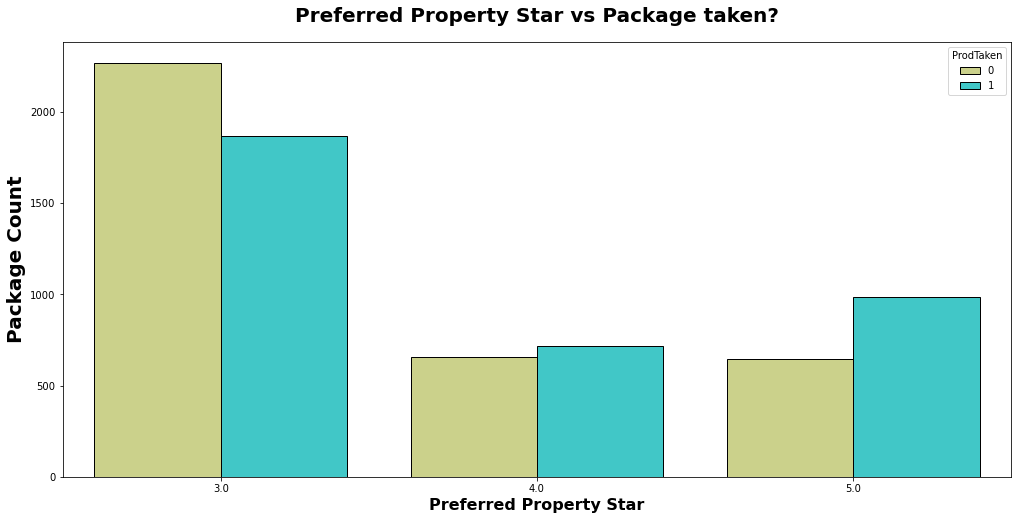

In [107]:
plt.subplots(figsize=(17,8))
sns.countplot(x="PreferredPropertyStar",hue="ProdTaken", data= df,ec = "black",palette="rainbow_r")
plt.title("Preferred Property Star vs Package taken?", weight="bold",fontsize=20, pad=20)
plt.ylabel("Package Count", weight="bold", fontsize=20)
plt.xlabel("Preferred Property Star", weight="bold", fontsize=16)
plt.show()

One thing one can do is compare preferred property star and product pitched

In [108]:
for i in range(3, 6):
    property_count = df['ProductPitched'].loc[(df['PreferredPropertyStar'] == i)]
    print(f"Product pitched for property {i}")
    print(property_count.value_counts()) 
    print('\n')

Product pitched for property 3
0.0    1833
1.0    1340
3.0     587
4.0     215
2.0     163
Name: ProductPitched, dtype: int64


Product pitched for property 4
0.0    695
1.0    386
3.0    166
4.0     67
2.0     57
Name: ProductPitched, dtype: int64


Product pitched for property 5
0.0    812
1.0    454
3.0    261
4.0     77
2.0     29
Name: ProductPitched, dtype: int64




**Note:**
- One thing I am finding strange is suggesting Basic and deluxe
- For business to improve, need to suggest Super Deluxe and King to the client who prefer 5 stars

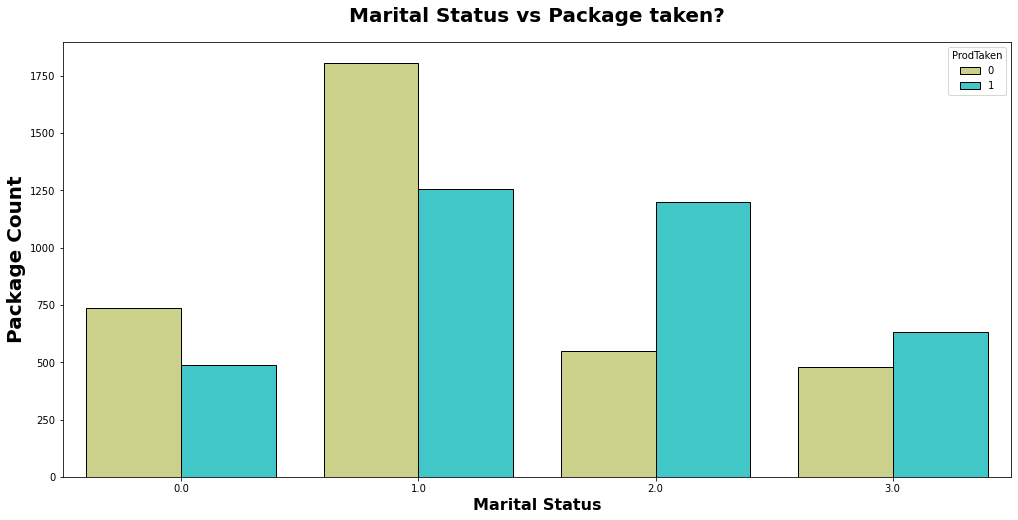

In [109]:
plt.subplots(figsize=(17,8))
sns.countplot(x="MaritalStatus",hue="ProdTaken", data= df,ec = "black",palette="rainbow_r")
plt.title("Marital Status vs Package taken?", weight="bold",fontsize=20, pad=20)
plt.ylabel("Package Count", weight="bold", fontsize=20)
plt.xlabel("Marital Status", weight="bold", fontsize=16)
plt.show()

**Note:**
- Single person with job is an ideal inquirer 
- Married person seemed to be confused and so they are inquiring but don't buy it
- Sales team need to work on to handle married inquirer 

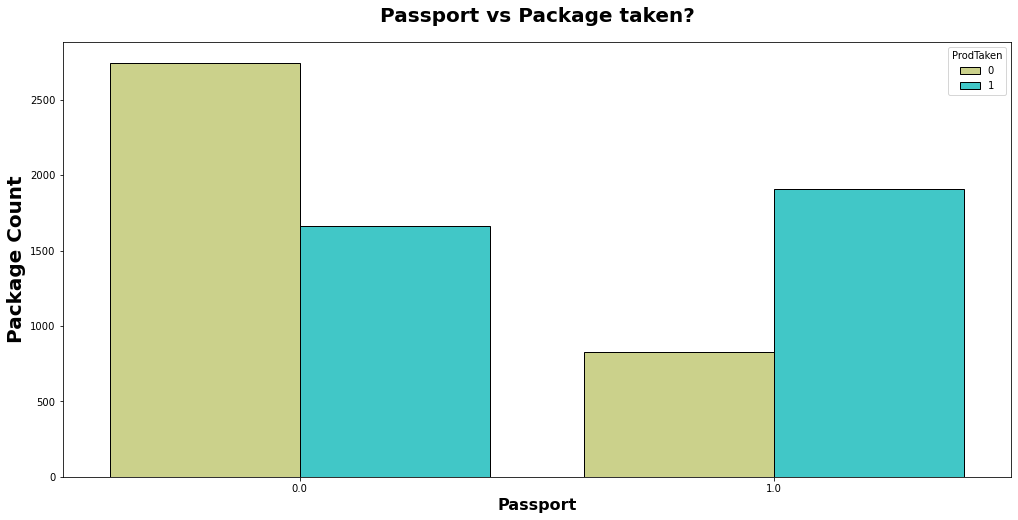

In [110]:
plt.subplots(figsize=(17,8))
sns.countplot(x="Passport",hue="ProdTaken", data= df,ec = "black",palette="rainbow_r")
plt.title("Passport vs Package taken?", weight="bold",fontsize=20, pad=20)
plt.ylabel("Package Count", weight="bold", fontsize=20)
plt.xlabel("Passport", weight="bold", fontsize=16)
plt.show()

**Note:**
- Some outliers can be seen from this graph
- Company seems to be new as very few seems to be taken trips more than 5
- And they are achieving the customers, so 2 and 3 number of trips taken are more

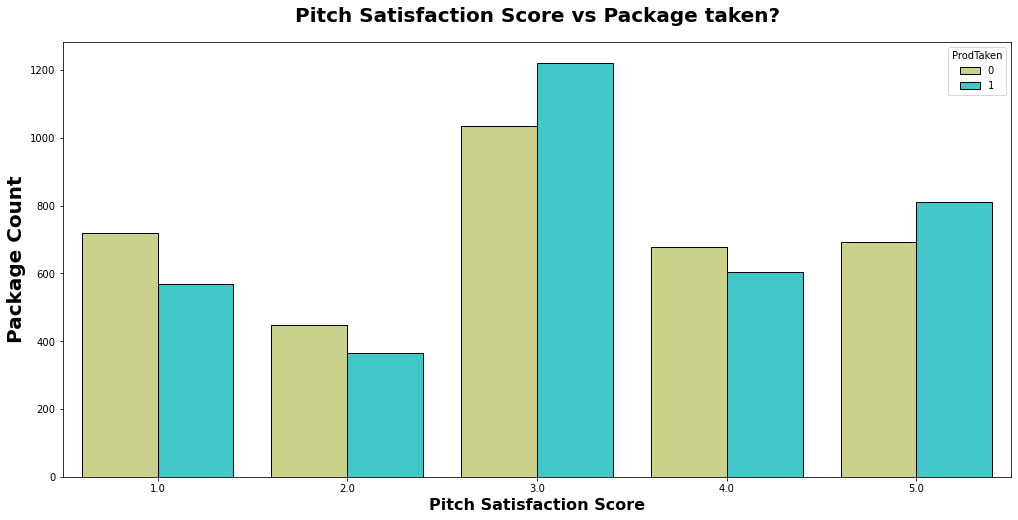

In [111]:
plt.subplots(figsize=(17,8))
sns.countplot(x="PitchSatisfactionScore",hue="ProdTaken", data= df,ec = "black",palette="rainbow_r")
plt.title("Pitch Satisfaction Score vs Package taken?", weight="bold",fontsize=20, pad=20)
plt.ylabel("Package Count", weight="bold", fontsize=20)
plt.xlabel("Pitch Satisfaction Score", weight="bold", fontsize=16)
plt.show()


Many customers are giving pitch score less than or equal to three, need to understand more about it

In [112]:
pitch_score_less_equal_3_taken = df.loc[(df['PitchSatisfactionScore'] <= 2) & (df['ProdTaken'] == 1)].shape[0]
pitch_score_less_equal_3_all = df.loc[(df['PitchSatisfactionScore'] <= 2)].shape[0]

pitch_score_more_3_taken = df.loc[(df['PitchSatisfactionScore'] >= 3) & (df['ProdTaken'] == 1)].shape[0]
pitch_score_more_3_all = df.loc[(df['PitchSatisfactionScore'] >= 3)].shape[0]

print(f"Ratio for the person with pitch less than or equal to 2 pitch rating score and buying package is {pitch_score_less_equal_3_taken/pitch_score_less_equal_3_all}")
print(f"Ratio for the person with pitch more than or equal to 3 pitch rating score and buying package is {pitch_score_more_3_taken/pitch_score_more_3_all}")


Ratio for the person with pitch less than or equal to 2 pitch rating score and buying package is 0.4444973797046212
Ratio for the person with pitch more than or equal to 3 pitch rating score and buying package is 0.5231013285742614


**Note:**
- There are many ratings score less than or equal to 2, and there is difference of around 5% in the buying ration
- Sales team really need to put on efforts

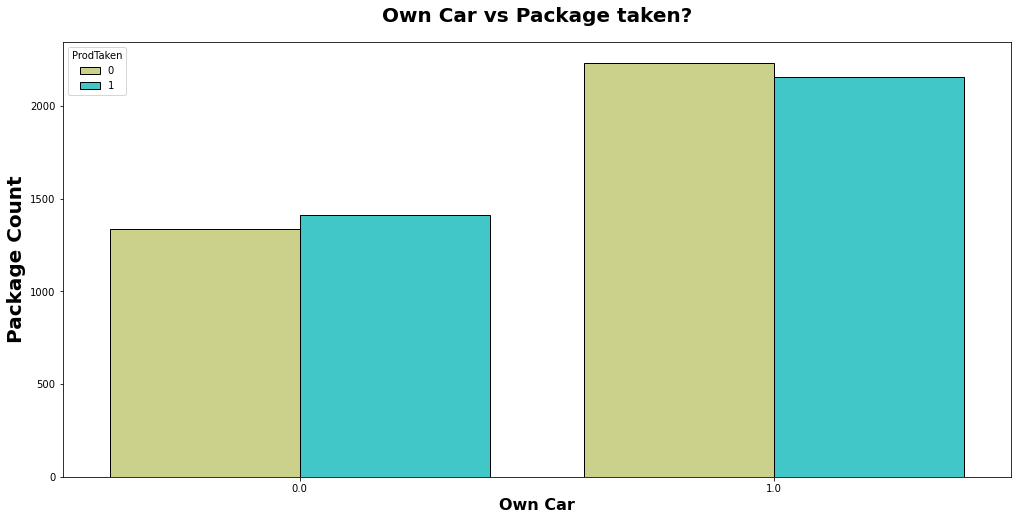

In [113]:
plt.subplots(figsize=(17,8))
sns.countplot(x="OwnCar",hue="ProdTaken", data= df,ec = "black",palette="rainbow_r")
plt.title("Own Car vs Package taken?", weight="bold",fontsize=20, pad=20)
plt.ylabel("Package Count", weight="bold", fontsize=20)
plt.xlabel("Own Car", weight="bold", fontsize=16)
plt.show()


**Note:**
- There has been many inquiries from the customer who can afford car, but we are unable to capitalized on them 

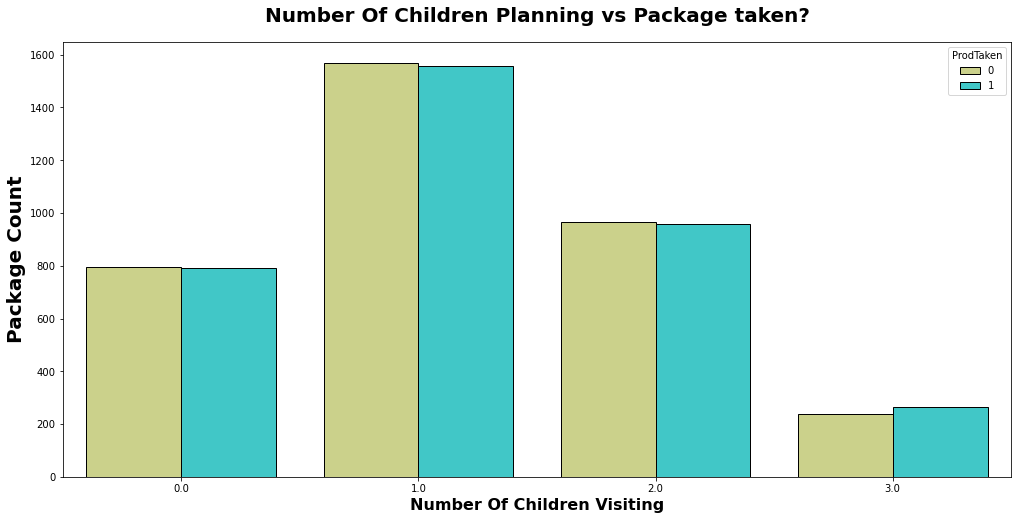

In [114]:
plt.subplots(figsize=(17,8))
sns.countplot(x="NumberOfChildrenVisiting",hue="ProdTaken", data= df,ec = "black",palette="rainbow_r")
plt.title("Number Of Children Planning vs Package taken?", weight="bold",fontsize=20, pad=20)
plt.ylabel("Package Count", weight="bold", fontsize=20)
plt.xlabel("Number Of Children Visiting", weight="bold", fontsize=16)
plt.show()

**Note:**
- Don't think the number of children visiting affect the person buying the package, but will try to analyse more in correlation part

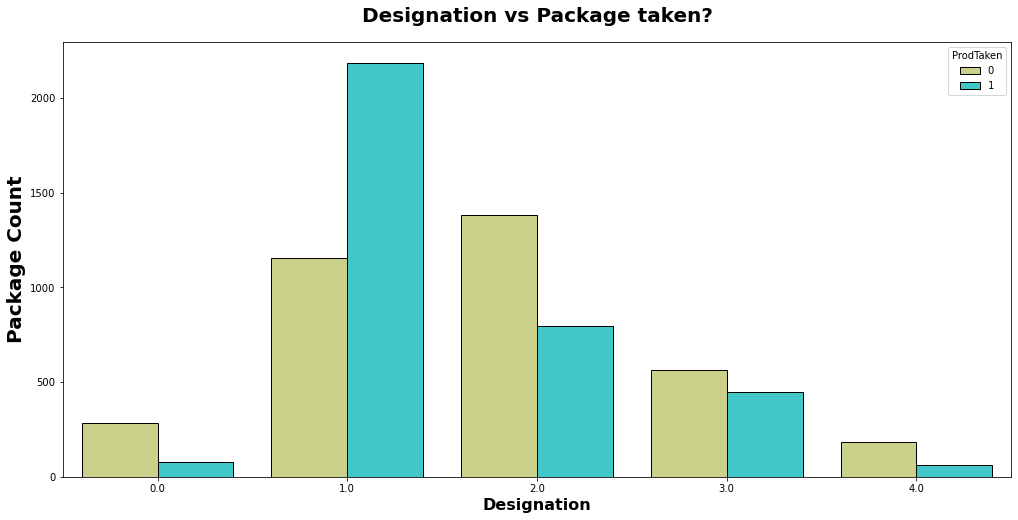

In [115]:
plt.subplots(figsize=(17,8))
sns.countplot(x="Designation",hue="ProdTaken", data= df,ec = "black",palette="rainbow_r")
plt.title("Designation vs Package taken?", weight="bold",fontsize=20, pad=20)
plt.ylabel("Package Count", weight="bold", fontsize=20)
plt.xlabel("Designation", weight="bold", fontsize=16)
plt.show()

**Note:**
- Company is getting the most inquiries from Manager and executive. 

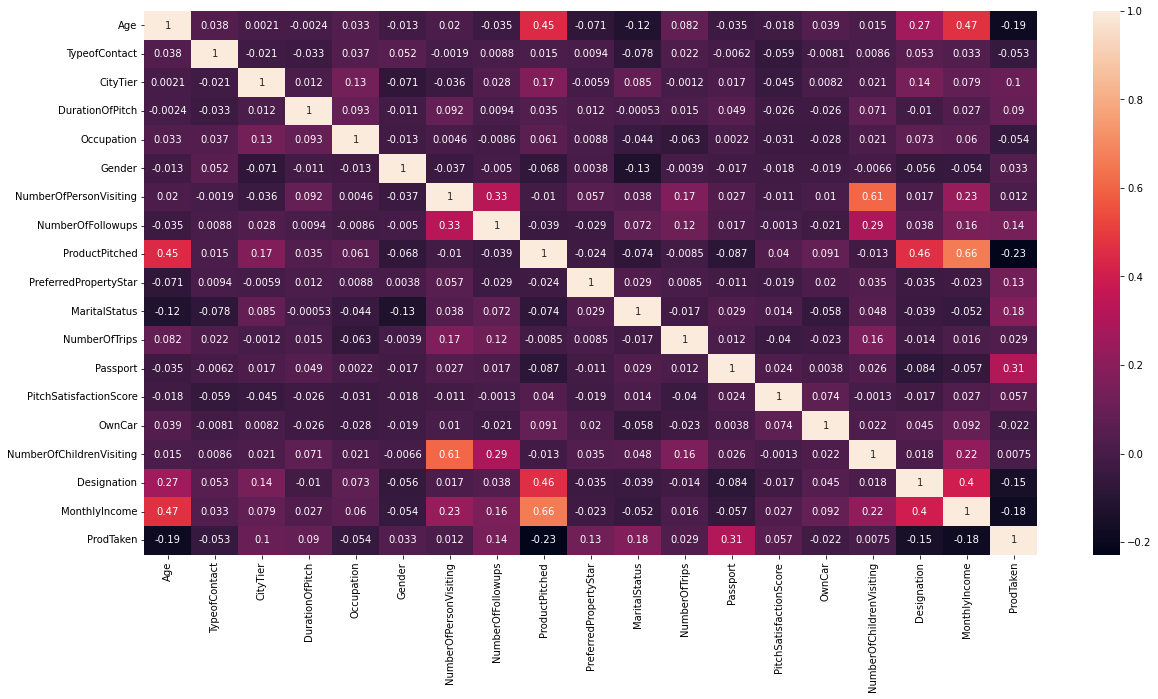

In [116]:
import seaborn as sns
    
plt.figure(figsize=(20,10))
ax = sns.heatmap(df.corr(), annot=True)

In [117]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(considered_features, df):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [118]:
compute_vif(df.columns, df)

,Variable,VIF
0,Age,1.406050
1,TypeofContact,1.019588
2,CityTier,1.107656
3,DurationOfPitch,1.036658
4,Occupation,1.046224
5,Gender,1.035559
6,NumberOfPersonVisiting,1.724781
7,NumberOfFollowups,1.212349
8,ProductPitched,2.239146
9,PreferredPropertyStar,1.033981


In [119]:
true_df = df.loc[df['ProdTaken'] == 0]
true_df.drop(columns=['ProdTaken'], inplace=True)

true_df.to_csv('colGan_False.csv', index=False)

In [120]:
X = df.drop(columns=['ProdTaken'], axis=1)
y = df['ProdTaken']
X.shape, y.shape

((7142, 18), (7142,))

In [121]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=36)
X_train.shape, X_test.shape

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(df.shape)

(7142, 19)


In [122]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=1000, min_samples_split=2, max_features= 'auto', max_depth= 20),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall


    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall


    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))

    print(classification_report(y_test, y_test_pred))
    print(cross_val_score(model, X, y, cv=3))
    
    print('='*35)
    print('\n')

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9846
- F1 score: 0.9846
- Precision: 0.9729
- Recall: 0.9972
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       355
           1       0.97      1.00      0.98       360

    accuracy                           0.98       715
   macro avg       0.99      0.98      0.98       715
weighted avg       0.98      0.98      0.98       715

[0.98446031 0.98194036 0.97815126]


Naive Bayes
Model performance for Training set
- Accuracy: 0.6855
- F1 score: 0.6841
- Precision: 0.6631
- Recall: 0.7533
----------------------------------
Model performance for Test set
- Accuracy: 0.6657
- F1 score: 0.6629
- Precision: 0.6430
- Recall: 0.7556
              precision    recall  f1-score   support

           0       0.70      0.57      0.63       355

In [123]:
X_train.shape 

(6427, 18)

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=36)
X_train.shape, X_test.shape

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = make_column_transformer(
    (StandardScaler(), numerical_columns),
    (OneHotEncoder(), categorical_columns)
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)


clf.fit(X_train, y_train)
# print("model score: %.3f" % clf.score(X_test, y_test))

print(categorical_columns)

['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'MaritalStatus', 'Designation']


In [125]:
df_test = pd.read_csv(r'C:\Users\wasim\tourism_package\packagePrediction\data\test_df.csv')

In [126]:
df_test.columns

X_test_raw = df.drop(columns=['ProdTaken'])
y_test_raw = df['ProdTaken']

X_test.iloc[[0]]

,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
6684,21.0,1.0,1.0,18.0,3.0,1.0,4.0,5.0,0.0,5.0,3.0,3.0,1.0,3.0,1.0,3.0,1.0,21278.0


In [127]:
clf.score(X_test_raw, y_test_raw)

0.9985998319798376

In [128]:
df = pd.DataFrame(columns=X_train.columns)
df.loc[0] = [46.0,1.0,1.0,13.0,2.0,1.0,3.0,4.0,1.0,5.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,19615.0]


In [129]:
df

,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,46.0,1.0,1.0,13.0,2.0,1.0,3.0,4.0,1.0,5.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,19615.0


In [130]:
print(pd.__version__)

1.4.2


In [132]:
f = open(r'C:\Users\wasim\tourism_package\packagePrediction\data\test_df.csv','r')
lines = f.readlines()[1:]
for i in lines:
    df = pd.DataFrame()
    i = i.split(',')
    y = i[-1]
    df.loc[0] = i[:-1]

    print(clf.predict(df), y)

lines

['43.0,1.0,3.0,8.0,3.0,2.0,3.0,3.0,1.0,3.0,1.0,2.0,1.0,3.0,0.0,0.0,2.0,22847.0,0\n',
 '46.0,1.0,1.0,13.0,2.0,1.0,3.0,4.0,1.0,5.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,19615.0,0\n',
 '41.0,1.0,1.0,18.0,1.0,1.0,2.0,3.0,2.0,3.0,0.0,2.0,0.0,4.0,1.0,0.0,4.0,34545.0,1\n',
 '36.0,1.0,1.0,21.0,2.0,2.0,3.0,5.0,0.0,4.0,1.0,3.0,1.0,5.0,1.0,2.0,1.0,22421.0,1\n',
 '28.0,1.0,1.0,12.0,1.0,2.0,3.0,5.0,3.0,3.0,1.0,3.0,1.0,3.0,0.0,1.0,3.0,31486.0,0\n',
 '24.0,0.0,3.0,16.0,3.0,2.0,3.0,4.0,0.0,5.0,1.0,3.0,0.0,5.0,1.0,1.0,1.0,20468.0,1\n',
 '58.0,1.0,3.0,16.0,3.0,2.0,2.0,3.0,4.0,3.0,2.0,1.0,0.0,3.0,0.0,1.0,0.0,28872.0,0\n',
 '32.0,0.0,3.0,9.0,2.0,1.0,3.0,4.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,1.0,3.0,28530.0,0\n',
 '50.0,0.0,1.0,6.0,2.0,1.0,3.0,3.0,2.0,4.0,1.0,4.0,1.0,1.0,0.0,2.0,4.0,33172.0,0\n',
 '39.0,1.0,1.0,13.0,1.0,1.0,3.0,4.0,1.0,3.0,2.0,2.0,0.0,2.0,1.0,0.0,2.0,19553.0,0\n',
 '39.0,1.0,3.0,13.0,2.0,2.0,3.0,3.0,0.0,3.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,19534.0,1\n',
 '41.0,0.0,1.0,13.0,2.0,1.0,2.0,5.0,2.0,3.0,1.0,2.0,0.0,4

In [133]:
import pickle

pickle.dump(clf, open(r"C:\Users\wasim\tourism_package\saved_models\model.pkl", 'wb'))

In [134]:
import sklearn


sklearn.__version__

'0.24.2'

In [135]:
os.chdir(r'c:\\Users\\wasim\\tourism_package')

In [136]:
from packagePrediction.entity.config_entity import DataIngestionConfig


In [137]:
import os

os.chdir(r"C:\Users\wasim\tourism_package")

In [138]:
import sys
import mysql.connector as conn
import pandas as pd

from packagePrediction.entity.config_entity import DataIngestionConfig
from packagePrediction.logger import logging
from packagePrediction.exception import PackageException
from packagePrediction.config.configuration import Configuartion

class DataIngestion:
    def __init__(self,data_ingestion_config:DataIngestionConfig ):
        try:
            logging.info(f"{'>>'*20}Data Ingestion log started.{'<<'*20} ")
            self.data_ingestion_config = data_ingestion_config

        except Exception as e:
            raise PackageException(e,sys)

    def get_raw_data(self):

        mydb = conn.connect(
        host="localhost",
        user="root",
        password="password"
        )

        cursor = mydb.cursor()
        cursor.execute("select * from tourist_package.test_df1")
        df = pd.DataFrame(cursor.fetchall())    

        raw_data_dir = self.data_ingestion_config.raw_data_dir

        if os.path.exists(raw_data_dir):
            os.remove(raw_data_dir)

        os.makedirs(raw_data_dir,exist_ok=True)

        df.to_csv(os.path.join(raw_data_dir, 'data.csv'))

In [139]:
config = Configuartion()
data_ingestion = DataIngestion(data_ingestion_config=config.get_data_ingestion_config())
data_ingestion.get_raw_data()

In [140]:
from packagePrediction.util.util import ConnectDatabase